# Ryerson University $~~~~~~~~~~~~~~~~~~~~~~~~~~~$ $~~~~~~~~~~~~~~~~~~~~~~~~$ Laboratory of Innovations in Transportation (LiTans)
$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ 
$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$
$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ 
$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ 

# <center> <font color='royalblue'> “Impacts of the COVID-19 Pandemic on Ridesourcing Services in Small Towns and Large Cities”</font> </center> 

# <center> <font color='royalblue'> Part Two: Percent Reduction in Daily Demand Model </font> </center> 


$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ 
$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$

# <center>Nael Alsaleh & Bilal Farooq </center>
$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$
# January 2022

<hr style="border:2px solid gray"> </hr>

# Inputs

1. Modelling dataset that includes all the variables shown below.

Month, Day_of_week, Weekend, Cases, Deaths, Hospitalizations, Positive_Rate, Partially_Vaccinated, Fully_Vaccinated, Stringency_Index, and Per_Reduction 

# Dependencies

In order to run this code successfully, you will need to:
1. Latest version of Python
2. Installing the required libraries.

# Implementation

The implementation of the direct demand model has been divided into two parts:

1. Modelling
2. Model Interpretation

<hr style="border:2px solid gray"> </hr>

# <font color='forestgreen'> Part 1. Modelling </font>

A) Import the required packages

In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

B) Import the Training Data

In [2]:
Demand_Reduction_Data = pd.read_csv('Reduction_Daily_Demand.csv')

# Define the explanatory and response variables
X = Demand_Reduction_Data[['Month', 'Day_of_week', 'Weekend', 'Cases', 'Deaths', 'Hospitalizations', 'Positive_Rate', 
                           'Partially_Vaccinated', 'Fully_Vaccinated', 'Stringency_Index']]

Y = Demand_Reduction_Data['Per_Reduction']
X = StandardScaler().fit_transform(X)

# Split the data into training and testing
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.20, 
random_state = 101)

# Print the shape of training and testing datasets
print (X_Train.shape)
print (Y_Train.shape)
print (X_Test.shape)
print (Y_Test.shape)

(5, 10)
(5,)
(2, 10)
(2,)


C) Find the optimum Hyperparameters for the Trip Distribution Model (Random Forest Model) using Bayesian Optimization Method

In [57]:
space = {'criterion': hp.choice('criterion', ['squared_error', 'absolute_error']),
        'max_depth': hp.quniform('max_depth', 10, 150, 10),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2']),
        'min_samples_leaf': hp.uniform ('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50, 100, 150, 300]),
        'max_leaf_nodes' : hp.choice('max_leaf_nodes', [10, 50, 100, 150, 300, None]),
        'bootstrap' : hp.choice('bootstrap', [True, False])
         }
def objective(space):
    model = RandomForestRegressor(criterion = space['criterion'], 
                                  max_depth = space['max_depth'],
                                  max_features = space['max_features'],
                                  min_samples_leaf = space['min_samples_leaf'],
                                  min_samples_split = space['min_samples_split'],
                                  n_estimators = space['n_estimators'],
                                  max_leaf_nodes =space['max_leaf_nodes'],
                                  bootstrap = space['bootstrap'],
                                 )
    
    scores = cross_val_score(model, X_Train, Y_Train, cv = 5, scoring='neg_mean_squared_error').mean() 
    #return scores.mean()
    return {'loss': - scores, 'status': STATUS_OK }
    
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 100,
            trials= trials)
best

100%|██████████| 100/100 [00:09<00:00, 10.50trial/s, best loss: 0.035339254754822136]


{'bootstrap': 1,
 'criterion': 1,
 'max_depth': 120.0,
 'max_features': 2,
 'max_leaf_nodes': 2,
 'min_samples_leaf': 0.22230474908975942,
 'min_samples_split': 0.10444489123541532,
 'n_estimators': 0}

D)  Apply the optimal  architectures  of  the  algorithms  on  the  testing  set

In [61]:
crit = {0: 'squared_error', 1: 'absolute_error'}
feat = {0: 'auto', 1: 'sqrt', 2: 'log2'}
est = {0: 10, 1: 50, 2: 100,  3: 150, 4:300}
leaf_node = {0: 10, 1: 50, 2: 100, 3: 150, 4: 300, 5: None}
boot = {0: True, 1: False}

trainedforest = RandomForestRegressor( criterion = crit[best['criterion']], 
                                       max_depth = best['max_depth'], 
                                       max_features = feat[best['max_features']], 
                                       min_samples_leaf = best['min_samples_leaf'], 
                                       min_samples_split = best['min_samples_split'], 
                                       n_estimators = est[best['n_estimators']], 
                                       max_leaf_nodes = leaf_node[best['max_leaf_nodes']],
                                       bootstrap = boot[best['bootstrap']]
                                      ).fit(X_Train,Y_Train)

predictionforest = trainedforest.predict(X_Test)

y_true = Y_Test # Your real values / test labels
y_pred = predictionforest # The predictions from your ML / RF model

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
print('R^2:', metrics.r2_score(y_true, y_pred))

Mean Absolute Error (MAE): 0.254650133
Mean Squared Error (MSE): 0.08197313017814471
Root Mean Squared Error (RMSE): 0.2863095006774045


# <font color='forestgreen'> Part 2: Model Interpretation Using SHAP (SHapley  Additive  exPlanations)</font>

100%|██████████| 2/2 [00:00<00:00, 28.77it/s]


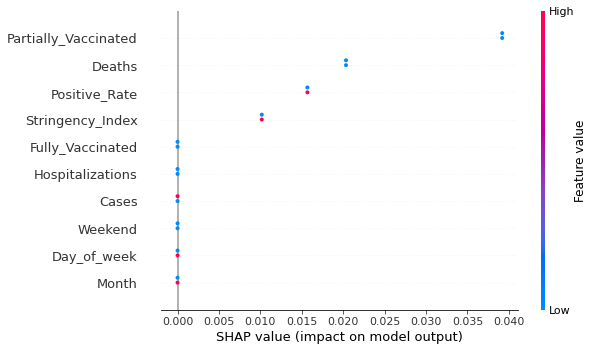

In [62]:
X_Test_new = pd.DataFrame(X_Test, columns = ['Month', 'Day_of_week', 'Weekend', 'Cases', 'Deaths', 'Hospitalizations', 'Positive_Rate', 
                                             'Partially_Vaccinated', 'Fully_Vaccinated', 'Stringency_Index'])

import shap
X_train_summary = shap.kmeans(X_Train, 5)


rf_explainer_ = shap.KernelExplainer(trainedforest.predict,X_train_summary, nsamples=100)
rf_shap_values_ = rf_explainer_.shap_values(X_Test_new)

shap.summary_plot(rf_shap_values_, X_Test_new, show=False, max_display=X.shape[1])